# Plot numerically computed matern correlation lengths compared to theory

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import cmocean
import warnings

In [2]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [3]:
plt.style.use('./correlation.mplstyle')

In [4]:
horizontal_factor = 1
n_ranges = [5, 10, 15, 20]
log10tol = -3
n_samples = 1000
n_applications = 2
corrs = []
for n_range in n_ranges:
    fname = f"/scratch2/tsmith/generic-matern-covariance/sampling/llc90/zstores/matern-corr-{n_applications:02d}apps/log10tol{log10tol:03d}.{n_range:02d}dx.{horizontal_factor:02}xi.{n_samples}samples"
    corrs.append(xr.open_zarr(fname))
    
cds = xr.concat(corrs, dim='n_range')

In [5]:
cds.nbytes / 1e9

2.232829536

In [6]:
cds.load();

## Comparison to theory

In [7]:
k = 25
ix = 90
iy = 165

In [34]:
def plot_correlation(xds, dim, dsel, ax):
    
    adims = tuple(d for d in ('ix','iy','k') if d != dim)
    
    if dim[-1] == 'x':
        lbl = 'i'
    elif dim[-1] == 'y':
        lbl = 'j'
    elif dim[-1] == 'k':
        lbl = 'k'
    else:
        raise ValueError("Unexpected dimension for label")
    
    aspec = ax.get_subplotspec()
    theory_label = r'$r\,(d; L, M)$'
    theory_label = theory_label if aspec.is_first_col() and xds.n_range==5 else None
    exp_label=r'$L$ = %d' % xds.n_range if aspec.is_first_col() else None
    
    # for simplicity, just showing positive, but it's the same either way...
    condition = xds['shifty'] >= 0
    if dim == 'k':
        condition = condition & (xds.rho_hat<25)
        
    x = xds['rho_hat'].where(condition)
    theory = xds[f'ideal_corr'].where(condition)
    yavg = xds[f"corr_{dim}"].where(condition).mean(adims)
    ystd = xds[f"corr_{dim}"].where(condition).std(adims)
    spread = xds[f"corr_{dim}"].where(condition).quantile([.1, .9], dim=adims)
    
    p = ax.plot(x, theory, label=theory_label, color='black')
    ax.fill_between(x,
                    spread.isel(quantile=0),
                    spread.isel(quantile=-1),
                    alpha=.3,
                    label=exp_label)

    ax.axhline(y=0.14, color='gray', alpha=.2)
    ax.set(xlabel=r'$\delta{%s}$' % lbl,ylabel='',title='')

In [35]:
def big_corr_plot(xds, dim, dsel):
    
    ncols = 1
    nrows = 1
    
    fig,ax = plt.subplots(nrows,ncols,figsize=(5,5),
                          constrained_layout=True,
                          )
    
    n_applications = xds.n_applications.values
    for n_range in xds.n_range.values:
        plotme = xds.sel({dim:dsel, "n_range":n_range, "n_applications":n_applications}).squeeze()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            plot_correlation(plotme, dim, dsel, ax)
            
            
    ax.set_ylabel('Correlation', labelpad=-10)
    ax.set(xlim=[None, 40], xticks=np.arange(0,41,10), yticks=[0, 1])
    ax.set_xlabel('Distance')
    
    ax.legend(title=r"$M=%d$" % n_applications)
    return fig, ax

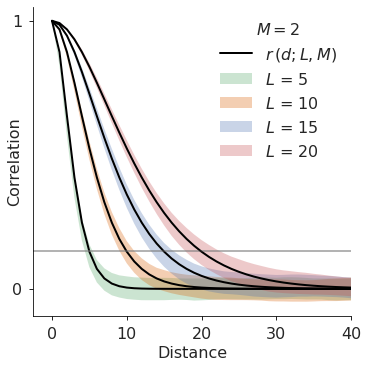

In [36]:
fig, axs = big_corr_plot(cds, 'ix', ix)
fig.savefig(f'{fig_dir}/single_panel_theory_comparison.pdf', bbox_inches='tight')